In [1]:
#Importing libraries and loading dataset
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime

                            
dataset = pd.read_csv('preprocessed_dataset_kathmandu.csv',index_col=0)                            

ModuleNotFoundError: No module named 'numpy'

In [2]:
dataset.head()

,PM2.5,O3,TEMPERATURE,PRESSURE,DEWPOINT,RAIN
date_and_time,,,,,,
2019-01-01 00:00:00,0.098577,0.000000,0.060150,0.814545,0.243077,0.0
2019-01-01 01:00:00,0.114837,0.000000,0.112782,0.847273,0.243077,0.0
2019-01-01 02:00:00,0.137195,0.008475,0.150376,0.880000,0.264615,0.0
2019-01-01 03:00:00,0.178862,0.033898,0.285714,0.909091,0.332308,0.0
2019-01-01 04:00:00,0.197154,0.161017,0.394737,0.916364,0.252308,0.0


In [3]:
# load dataset
df = pd.read_csv('preprocessed_dataset_kathmandu.csv', header=0, index_col=0)
df.describe()

,PM2.5,O3,TEMPERATURE,PRESSURE,DEWPOINT,RAIN
count,7637.000000,7637.000000,7637.000000,7637.000000,7637.000000,7637.000000
mean,0.045832,0.245428,0.561692,0.524710,0.673810,0.012659
std,0.045836,0.179375,0.209576,0.207259,0.189957,0.047958
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.018293,0.101695,0.413534,0.356364,0.504615,0.000000
50%,0.036585,0.211864,0.601504,0.552727,0.701538,0.000000
75%,0.060976,0.355932,0.714286,0.694545,0.852308,0.003300
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [4]:
dataset_columns = df.columns.tolist()
dataset_columns

['PM2.5', 'O3', 'TEMPERATURE', 'PRESSURE', 'DEWPOINT', 'RAIN']

In [8]:
import numpy as np

mean_pm = df['PM2.5'].mean()
std_pm = df['PM2.5'].std()
z_scores = (df['PM2.5'] - mean_pm) / std_pm

threshold = 3
df = df[np.abs(z_scores) < threshold]

In [9]:
from sklearn.preprocessing import LabelEncoder

# Encode non categorical values
values = df.values
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
values = values.astype('float32')
values[:,4]

array([28., 28., 35., ..., 24., 26., 31.], dtype=float32)

In [10]:
#Normalising data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_dataset = scaler.fit_transform(values)

In [12]:
#Creating a window for previous data
def to_supervised(train):
  window_size = 2
  X = []
  Y = []
  for i in range(window_size, len(train)):
    X.append(train[i-window_size:i,:])
    Y.append(train[i,0:1])
    
  return X,Y

In [13]:
X, Y = to_supervised(scaled_dataset)
X = np.array(X)
Y = np.array(Y)
print('Y' ,Y.shape)
print('X' ,X.shape)


Y (7564, 1)
X (7564, 2, 6)


In [16]:
from sklearn.model_selection import train_test_split


# Step 1: First, split into training and testing sets (80% for training and 20% for testing)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)

# Check the shapes of the splits
print("X_train shape after first split:", X_train.shape)
print("X_test shape after first split:", X_test.shape)

# Step 2: Split the training data further into training and validation sets
# 80% of the training data for training and 20% of it for validation
n_val = int(X_train.shape[0] * 0.2)  # 20% for validation from the training data

# Manually create validation and training data by slicing the X_train and y_train
X_val, X_train = X_train[:n_val], X_train[n_val:]
y_val, y_train = y_train[:n_val], y_train[n_val:]

# Check the shapes of the final splits
print("X_train shape after final split:", X_train.shape)
print("X_val shape after final split:", X_val.shape)
print("X_test shape after final split:", X_test.shape)

print("y_train shape after final split:", y_train.shape)
print("y_val shape after final split:", y_val.shape)
print("y_test shape after final split:", y_test.shape)


X_train shape after first split: (6051, 2, 6)
X_test shape after first split: (1513, 2, 6)
X_train shape after final split: (4841, 2, 6)
X_val shape after final split: (1210, 2, 6)
X_test shape after final split: (1513, 2, 6)
y_train shape after final split: (4841, 1)
y_val shape after final split: (1210, 1)
y_test shape after final split: (1513, 1)


In [17]:
# import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
import keras_tuner as kt
import numpy as np

# Ensure n_steps and n_features are defined
n_steps = X_train.shape[1]  # Define number of time steps
n_features = 6  # Example feature count (update accordingly)

# Define hyperparameter tuning function
def build_model(hp):
    model = Sequential()
    
    # Single LSTM layer with tuning of units
    model.add(LSTM(
        units=hp.Choice('units', [8, 16, 32, 64, 128]),  # Tuning hidden units
        activation='relu',
        input_shape=(n_steps, n_features)
    ))
    
    # Dropout layer with tuning of dropout rate
    model.add(Dropout(hp.Choice('dropout', [0.2, 0.3, 0.4])))  # Tuning dropout rate
    
    # Output layer
    model.add(Dense(1))  # Regression output
    
    # Optimizer Selection with different learning rates
    optimizer_choice = hp.Choice('optimizer', ['SGD', 'Adam', 'RMSprop'])  # Tuning optimizer
    
    if optimizer_choice == 'SGD':
        optimizer = SGD(
            learning_rate=hp.Choice('sgd_lr', [0.01, 0.005, 0.001, 0.0005]),  # Tuning SGD learning rate
            momentum=0.9, nesterov=True
        )
    elif optimizer_choice == 'Adam':
        optimizer = Adam(
            learning_rate=hp.Choice('adam_lr', [0.001, 0.0005, 0.0001, 0.00005])  # Tuning Adam learning rate
        )
    else:  # RMSprop
        optimizer = RMSprop(
            learning_rate=hp.Choice('rmsprop_lr', [0.001, 0.0005, 0.0001, 0.00005]),  # Tuning RMSprop learning rate
            rho=0.9
        )
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    
    return model

# Initialize Keras Tuner
tuner = kt.RandomSearch(
    build_model,
    objective='loss',  # Tuning for minimum loss
    max_trials=10,  # Number of trials for hyperparameter search
    executions_per_trial=1,  # Number of times each trial is executed
    directory='kt_tuning',  # Directory for storing tuning results
    project_name='lstm_aqi_tuning_v2'  # Project name for storing results
)

# Perform Hyperparameter Search (ensure you have validation data like X_split_val, y_split_val)
tuner.search(X_train, y_train, epochs=50, validation_data=(X_val, y_val), batch_size=32)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Output the best hyperparameters
print(f"""
Best LSTM units: {best_hps.get('units')}
Best Dropout Rate: {best_hps.get('dropout')}
Best Optimizer: {best_hps.get('optimizer')}
Best Learning Rate: {best_hps.get('sgd_lr' if best_hps.get('optimizer') == 'SGD' else 'adam_lr' if best_hps.get('optimizer') == 'Adam' else 'rmsprop_lr')}
""")

best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), batch_size=32)

Reloading Tuner from kt_tuning\lstm_aqi_tuning_v2\tuner0.json

Best LSTM units: 128
Best Dropout Rate: 0.2
Best Optimizer: Adam
Best Learning Rate: 0.0005

Epoch 1/50
152/152 [==============================] - 3s 7ms/step - loss: 0.0170 - mae: 0.0908 - val_loss: 0.0333 - val_mae: 0.1329
Epoch 2/50
152/152 [==============================] - 1s 6ms/step - loss: 0.0064 - mae: 0.0520 - val_loss: 0.0229 - val_mae: 0.1090
Epoch 3/50
152/152 [==============================] - 1s 5ms/step - loss: 0.0053 - mae: 0.0469 - val_loss: 0.0209 - val_mae: 0.1053
Epoch 4/50
152/152 [==============================] - 1s 5ms/step - loss: 0.0051 - mae: 0.0454 - val_loss: 0.0202 - val_mae: 0.1022
Epoch 5/50
152/152 [==============================] - 1s 6ms/step - loss: 0.0047 - mae: 0.0433 - val_loss: 0.0192 - val_mae: 0.1009
Epoch 6/50
152/152 [==============================] - 1s 6ms/step - loss: 0.0045 - mae: 0.0426 - val_loss: 0.0181 - val_mae: 0.0975
Epoch 7/50
152/152 [==============================] 

In [18]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Perform Predictions
y_pred = best_model.predict(X_test)

# Compute MSE, MAE, RMSE
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"RMSE: {rmse}")
print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"R²: {r2}")

48/48 [==============================] - 0s 3ms/step
RMSE: 0.08620274811983109
MSE: 0.007430913858115673
MAE: 0.06230977550148964
R²: 0.6661143152558291


In [19]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_mse, cv_mae, cv_rmse = [], [], []

for train_idx, val_idx in kf.split(X_train):
    X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
    y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

    # Train model on fold
    fold_model = tuner.hypermodel.build(best_hps)
    fold_model.fit(X_train_fold, y_train_fold, epochs=50, batch_size=32, verbose=0)

    # Predict
    y_val_pred = fold_model.predict(X_val_fold)

    # Compute Metrics
    fold_mse = mean_squared_error(y_val_fold, y_val_pred)
    fold_mae = mean_absolute_error(y_val_fold, y_val_pred)
    fold_rmse = np.sqrt(fold_mse)

    cv_mse.append(fold_mse)
    cv_mae.append(fold_mae)
    cv_rmse.append(fold_rmse)

# Print Cross Validation Results
# print(f"Cross-Validation MSE: {np.mean(cv_mse)} ± {np.std(cv_mse)}")
# print(f"Cross-Validation MAE: {np.mean(cv_mae)} ± {np.std(cv_mae)}")
# print(f"Cross-Validation RMSE: {np.mean(cv_rmse)} ± {np.std(cv_rmse)}")

print(f"Cross-Validation MSE: {np.mean(cv_mse)} (std: {np.std(cv_mse)})")
print(f"Cross-Validation MAE: {np.mean(cv_mae)} (std: {np.std(cv_mae)})")
print(f"Cross-Validation RMSE: {np.mean(cv_rmse)} (std: {np.std(cv_rmse)})")


31/31 [==============================] - 0s 3ms/step
Cross-Validation MSE: 0.00334368203766644 (std: 0.0005473758210428059)
Cross-Validation MAE: 0.035266466438770294 (std: 0.0013038974720984697)
Cross-Validation RMSE: 0.057637594640254974 (std: 0.004646434914320707)


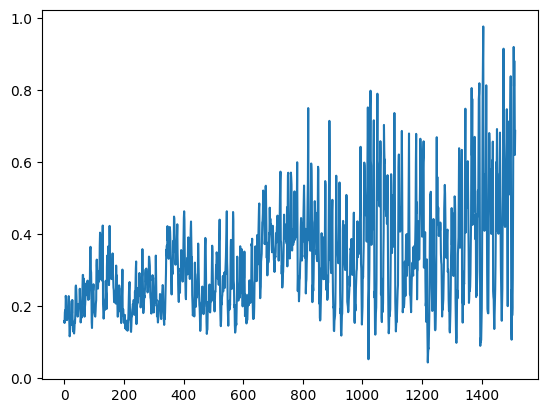

In [20]:
plt.plot(y_pred)

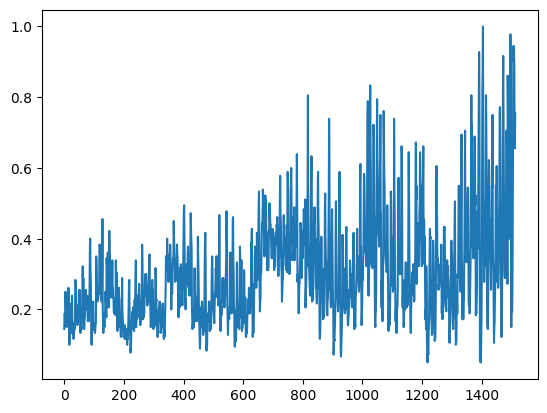

In [21]:
plt.plot(y_test)

In [22]:
_, train_acc = best_model.evaluate(X_train, y_train, verbose=0)
_, test_acc = best_model.evaluate(X_test, y_test, verbose=0)
print('Train: %.5f, Test: %.5f' % (train_acc, test_acc))

Train: 0.03736, Test: 0.06231


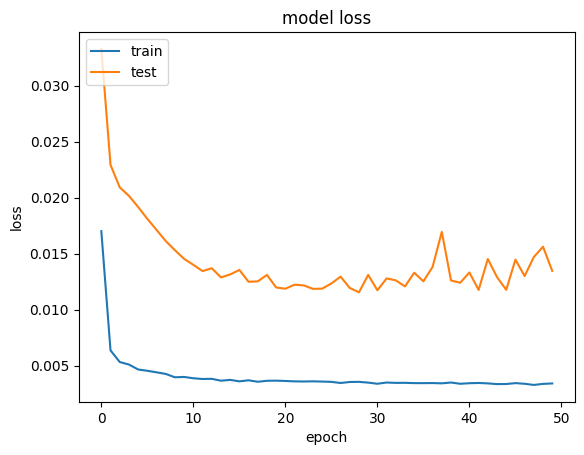

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

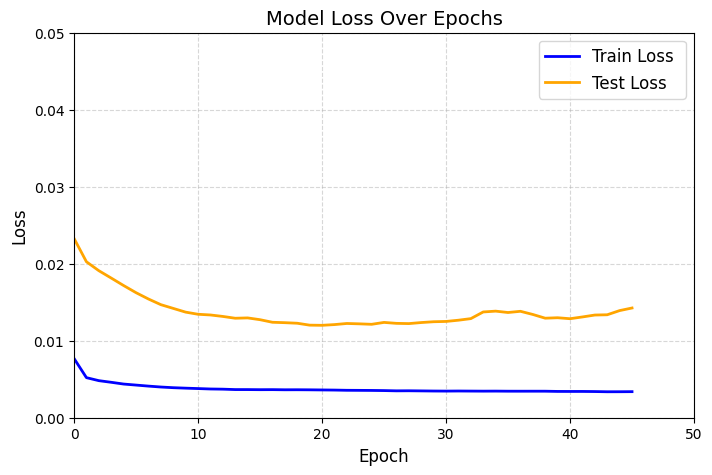

In [24]:
import numpy as np
import matplotlib.pyplot as plt

def moving_average(data, window_size=5):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Apply smoothing to the validation loss
val_loss_smooth = moving_average(history.history['val_loss'], window_size=5)
train_loss_smooth = moving_average(history.history['loss'], window_size=5)

# Plot the smoothed loss
plt.figure(figsize=(8, 5))
plt.plot(train_loss_smooth, label='Train Loss ', color='blue', linewidth=2)
plt.plot(val_loss_smooth, label='Test Loss', color='orange', linewidth=2)

# Improve readability
plt.title('Model Loss Over Epochs', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.xlim(0, 50)
plt.ylim(0, 0.05)  # Adjust y-axis if needed
plt.legend(loc='upper right', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

plt.show()


Epoch-wise validation loss:
Epoch 1: 0.03326944261789322
Epoch 2: 0.022919485345482826
Epoch 3: 0.020918626338243484
Epoch 4: 0.02016131393611431
Epoch 5: 0.0191645510494709
Epoch 6: 0.018107537180185318
Epoch 7: 0.017122406512498856
Epoch 8: 0.016126755625009537
Epoch 9: 0.015307260677218437
Epoch 10: 0.014534693211317062
Epoch 11: 0.014004812575876713
Epoch 12: 0.013445308431982994
Epoch 13: 0.013700703158974648
Epoch 14: 0.012883045710623264
Epoch 15: 0.013144639320671558
Epoch 16: 0.013547458685934544
Epoch 17: 0.012493163347244263
Epoch 18: 0.012529280036687851
Epoch 19: 0.013100657612085342
Epoch 20: 0.01198388822376728
Epoch 21: 0.011872774921357632
Epoch 22: 0.01223067007958889
Epoch 23: 0.012167122215032578
Epoch 24: 0.01185867190361023
Epoch 25: 0.011878838762640953
Epoch 26: 0.012339374050498009
Epoch 27: 0.012951008975505829
Epoch 28: 0.011938954703509808
Epoch 29: 0.011552040465176105
Epoch 30: 0.013106117956340313
Epoch 31: 0.011733081191778183
Epoch 32: 0.012791128829121

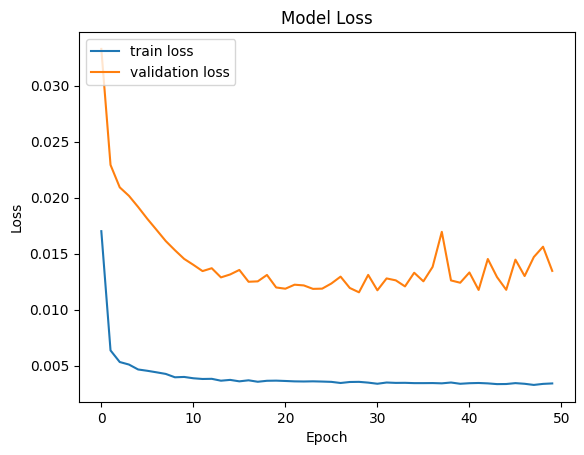

In [25]:
# Print validation loss at each epoch
print("Epoch-wise validation loss:")
for epoch, val_loss in enumerate(history.history['val_loss']):
    print(f"Epoch {epoch+1}: {val_loss}")

# Plotting the loss graph
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

Epoch-wise validation loss:
Epoch 1: 0.03326944261789322
Epoch 2: 0.022919485345482826
Epoch 3: 0.020918626338243484
Epoch 4: 0.02016131393611431
Epoch 5: 0.0191645510494709
Epoch 6: 0.018107537180185318
Epoch 7: 0.017122406512498856
Epoch 8: 0.016126755625009537
Epoch 9: 0.015307260677218437
Epoch 10: 0.014534693211317062
Epoch 11: 0.014004812575876713
Epoch 12: 0.013445308431982994
Epoch 13: 0.013700703158974648
Epoch 14: 0.012883045710623264
Epoch 15: 0.013144639320671558
Epoch 16: 0.013547458685934544
Epoch 17: 0.012493163347244263
Epoch 18: 0.012529280036687851
Epoch 19: 0.013100657612085342
Epoch 20: 0.01198388822376728
Epoch 21: 0.011872774921357632
Epoch 22: 0.01223067007958889
Epoch 23: 0.012167122215032578
Epoch 24: 0.01185867190361023
Epoch 25: 0.011878838762640953
Epoch 26: 0.012339374050498009
Epoch 27: 0.012951008975505829
Epoch 28: 0.011938954703509808
Epoch 29: 0.011552040465176105
Epoch 30: 0.013106117956340313
Epoch 31: 0.011733081191778183
Epoch 32: 0.012791128829121

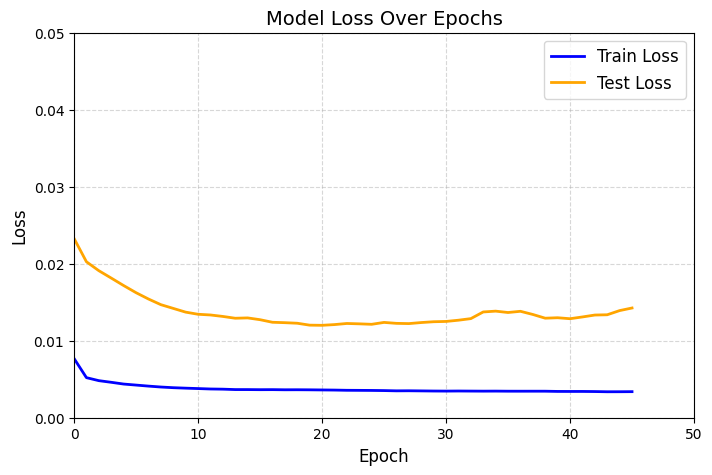

In [26]:
# Print validation loss at each epoch
print("Epoch-wise validation loss:")
for epoch, val_loss in enumerate(history.history['val_loss']):
    print(f"Epoch {epoch+1}: {val_loss}")

import numpy as np
import matplotlib.pyplot as plt

def moving_average(data, window_size=5):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Apply smoothing to the validation loss
val_loss_smooth = moving_average(history.history['val_loss'], window_size=5)
train_loss_smooth = moving_average(history.history['loss'], window_size=5)

# Plot the smoothed loss
plt.figure(figsize=(8, 5))
plt.plot(train_loss_smooth, label='Train Loss', color='blue', linewidth=2)
plt.plot(val_loss_smooth, label='Test Loss', color='orange', linewidth=2)

# Improve readability
plt.title('Model Loss Over Epochs', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.xlim(0, 50)
plt.ylim(0, 0.05)  # Adjust y-axis if needed
plt.legend(loc='upper right', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

plt.show()


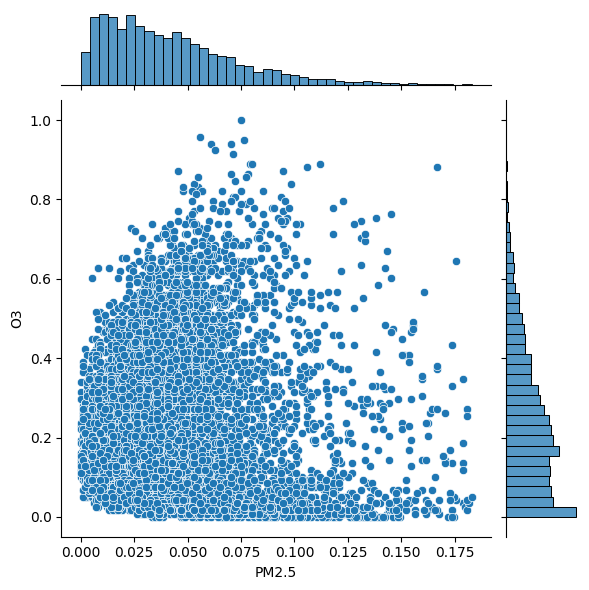

In [27]:
import seaborn as sns
sns.jointplot(x=df['PM2.5'], y=df['O3'], data = df)

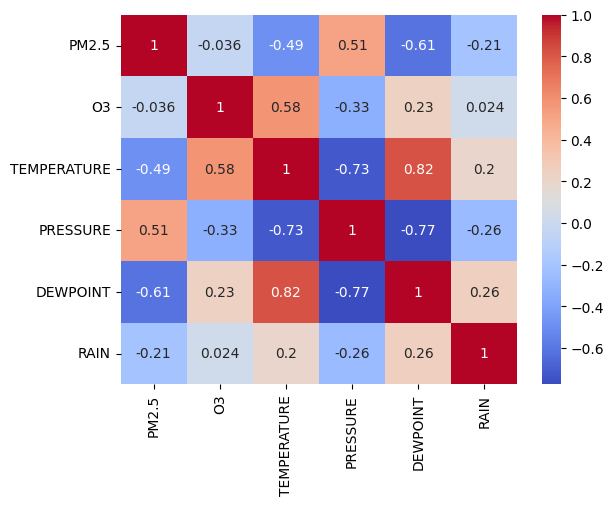

In [28]:
import seaborn as sns

sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.show()

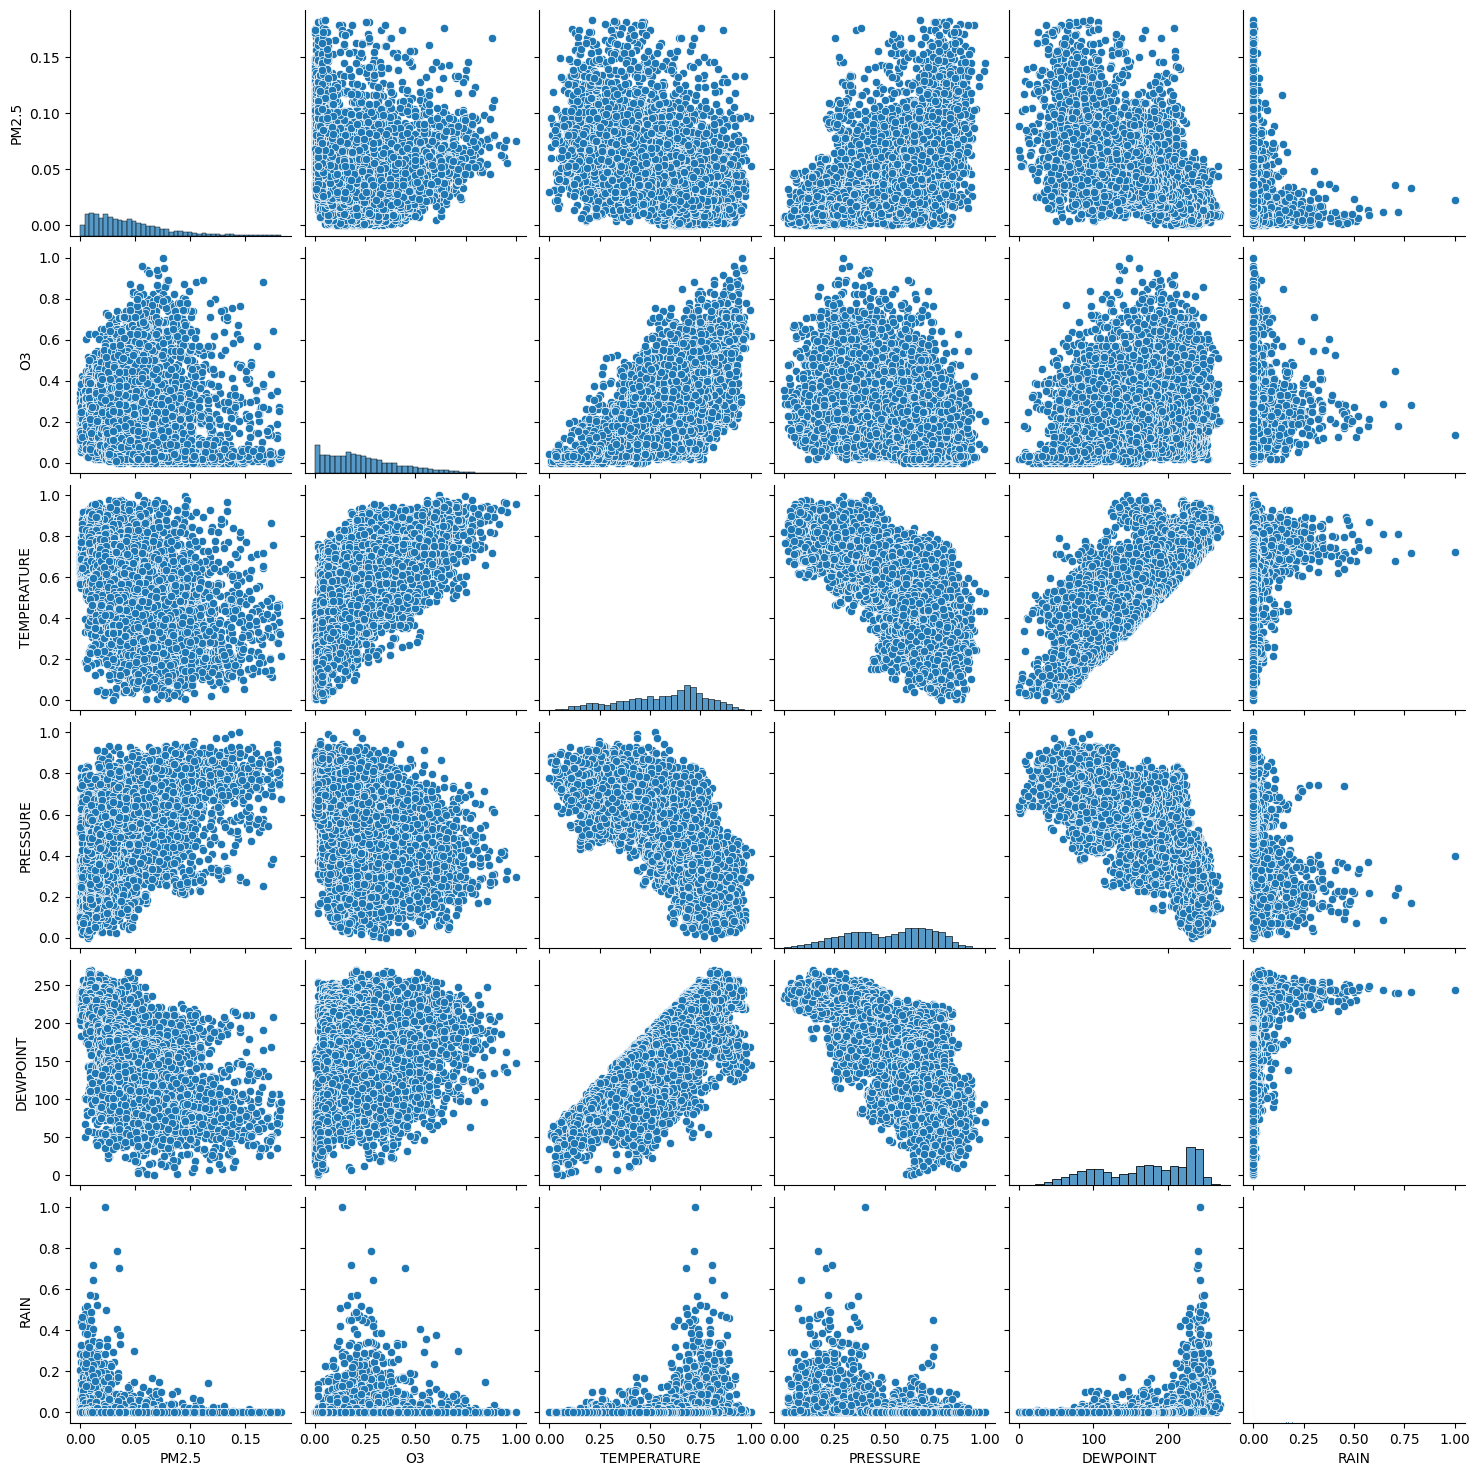

In [29]:
g = sns.pairplot(df)

<Axes: xlabel='PM2.5', ylabel='O3'>

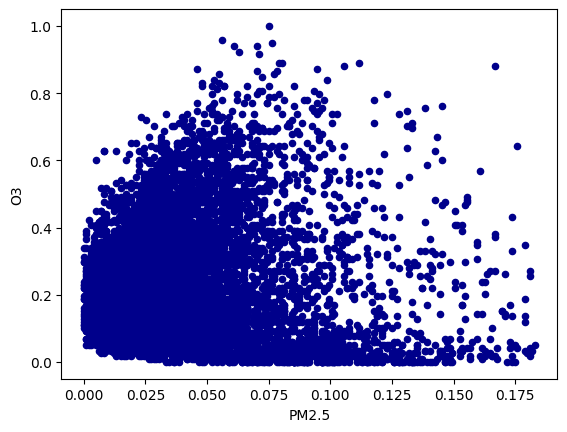

In [30]:
df.plot.scatter(x='PM2.5', y='O3', c='DarkBlue')

237/237 [==============================] - 1s 3ms/step


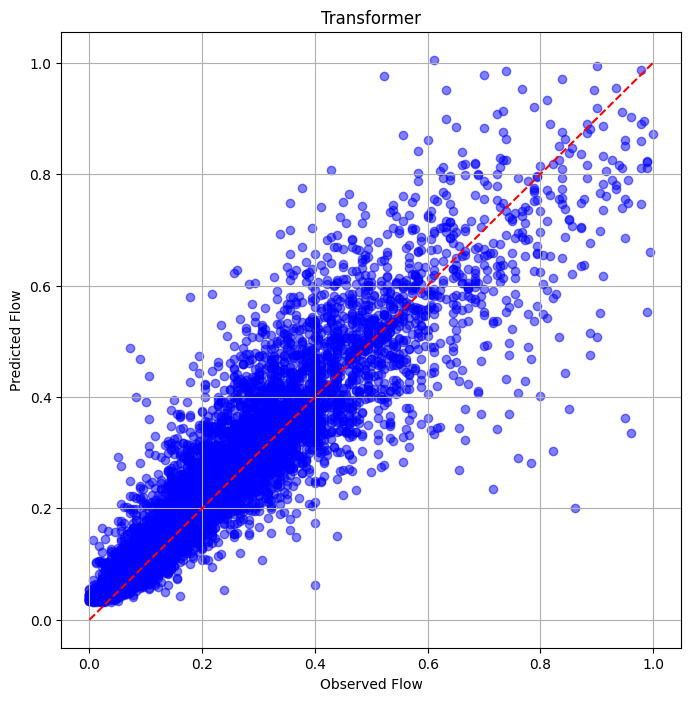

In [31]:
# Assuming you have arrays y_pred and y_observed
# y_pred and y_observed should have the same length
y_pred = best_model.predict(X).flatten()
y_observed = Y
plt.figure(figsize=(8, 8))
plt.scatter(y_observed, y_pred, color='blue', alpha=0.5)
plt.plot([min(y_observed), max(y_observed)], [min(y_observed), max(y_observed)], color='red', linestyle='--')
plt.title('Transformer')
plt.xlabel('Observed Flow')
plt.ylabel('Predicted Flow')
plt.grid(True)
plt.show()

In [36]:
import numpy as np
import matplotlib.pyplot as plt

def forecast_future_lstm(best_model, last_window, scaler, days=10):
    """
    Predict future values using an LSTM model based on the last available data.

    best_model: Trained LSTM model
    last_window: Last `window_size` observations (shape: (1, window_size, n_features))
    scaler: The MinMaxScaler used during training
    days: Number of future days to predict
    """
    future_predictions = []
    current_input = last_window.copy()  # Start with the last known data

    for _ in range(days):
        # Predict next step
        predicted_value = best_model.predict(current_input, verbose=0)
        
        # Save the predicted value
        future_predictions.append(predicted_value[0, 0])  # Assuming single-step forecast

        # Create a placeholder for the new feature vector (same number of features)
        new_feature_vector = np.zeros((1, 1, current_input.shape[2]))  # Shape: (1,1,n_features)
        new_feature_vector[0, 0, 0] = predicted_value[0, 0]  # Assign predicted value to first feature

        # Shift window by appending the new prediction
        current_input = np.concatenate((current_input[:, 1:, :], new_feature_vector), axis=1)

    # Convert list to numpy array
    future_predictions = np.array(future_predictions).reshape(-1, 1)

    # Create a placeholder with 6 features (same shape as original data)
    future_predictions_expanded = np.zeros((len(future_predictions), 6))  
    future_predictions_expanded[:, 0] = future_predictions[:, 0]  # Place predictions in first column

    # Apply inverse transform using the original scaler
    future_predictions = scaler.inverse_transform(future_predictions_expanded)[:, 0]  # Extract only the first column

    return future_predictions


38/38 [==============================] - 0s 2ms/step


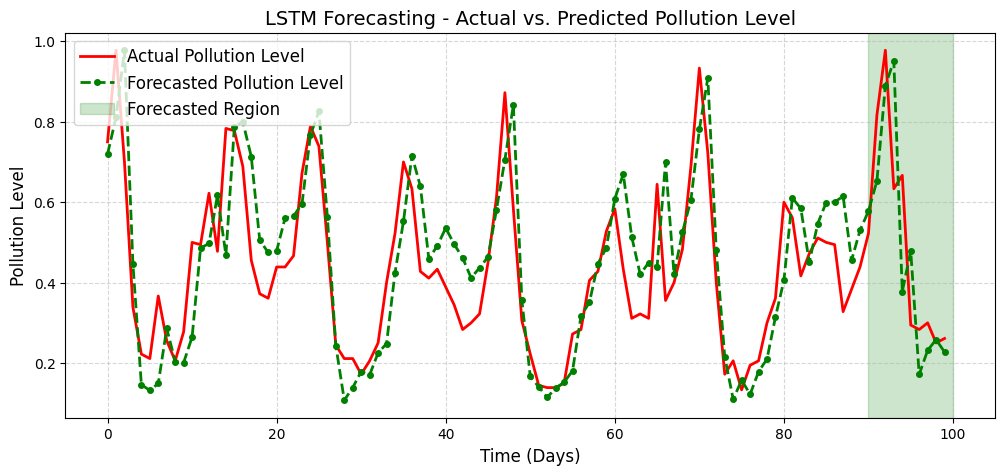

In [44]:
y_pred = best_model.predict(X_val)

# Plot actual vs. predicted values
plt.figure(figsize=(12, 5))
plt.plot(y_val[:100], color='red', linestyle='solid', linewidth=2, label='Actual Pollution Level')
plt.plot(y_pred[:100], color='green', linestyle='dashed', linewidth=2, marker='o', markersize=4, label='Forecasted Pollution Level')
plt.axvspan(len(y_test[:90]), len(y_test[:100]), color='green', alpha=0.2, label="Forecasted Region")

plt.title("LSTM Forecasting - Actual vs. Predicted Pollution Level", fontsize=14)
plt.xlabel("Time (Days)", fontsize=12)
plt.ylabel("Pollution Level", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(loc='upper left', fontsize=12)
plt.show()

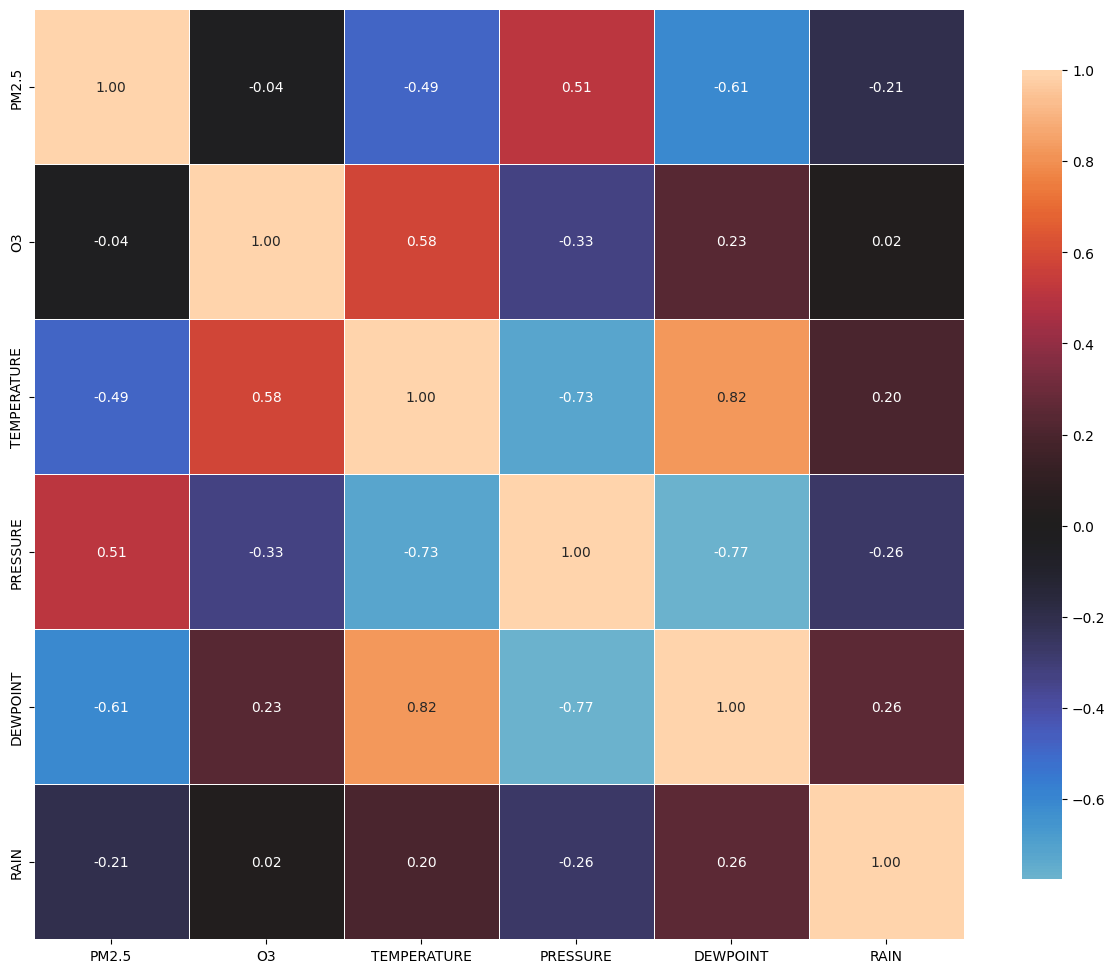

In [30]:
correlations = df.corr()
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f', square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70})
plt.show();